In [1]:
import glob, os
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import normalize
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
import pandas as pd


In [573]:
def otsu_thresh(image, is_normalised = True):
    # Set total number of bins in the histogram
    bins_num = 64

    # Get the image histogram
    hist, bin_edges = np.histogram(image, bins=bins_num)

    
    # Get normalized histogram if it is required
    if is_normalised:
        hist = np.divide(hist.ravel(), hist.max())

    # Calculate centers of bins
    bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.

    # Iterate over all thresholds (indices) and get the probabilities w1(t), w2(t)
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]

    # Get the class means mu0(t)
    mean1 = np.cumsum(hist * bin_mids) / weight1
    # Get the class means mu1(t)
    mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]

    inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

    # Maximize the inter_class_variance function val
    index_of_max_val = np.argmax(inter_class_variance)

    threshold = bin_mids[:-1][index_of_max_val]
    return threshold


In [141]:
def standardise(image_array):
    return image_array[...]/255.0

In [3]:
def blur(image_array, kernel):
    return cv2.blur(image_array, kernel)

In [4]:
def threshold(image_array):
    image_array = image_array.astype(np.uint8)
    
    threshold = otsu_thresh(image_array, is_normalised = False)
    
    _, thresh = cv2.threshold(image_array, threshold, 255, cv2.THRESH_BINARY_INV)
    
    return thresh

In [675]:
def erode(image_array):
    image_array = image_array.astype(np.uint8)
    
    kernel = np.ones((5,5), np.uint8)
    opening = cv2.morphologyEx(image_array, cv2.MORPH_OPEN, kernel, iterations=1)
    eroded = cv2.erode(opening, kernel, iterations=1)
    dilated = cv2.dilate(eroded, kernel, iterations=1)
    
    #dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    
    #ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(),255,0)
    #sure_fg = np.uint8(sure_fg)
    
    #unknown = cv2.subtract(sure_bg, sure_fg)
    
    return dilated

In [676]:
def contour(image_array, min_size):
    #Get contours
    img_contours = cv2.findContours(image_array, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2]
    img_contours = sorted(img_contours, key=cv2.contourArea)
    
    mask = np.zeros(image_array.shape[:2], np.uint8)
    
    for i, contour in enumerate(img_contours):
        if(contour.size > min_size):  
            cv2.drawContours(mask, [contour],-1, 255, -1)
        
    new_img = cv2.bitwise_and(image_array, image_array, mask=mask)
    
    return new_img
    

In [856]:
import cv2

def preprocess(image_array):
    result = image_array
    #result = blur(result, (1,1))
    #result = threshold(result)
    #result = contour(result, 20)
    #result = erode(result)
    
    return result.reshape(image_array.shape[0], image_array.shape[1], 1)
    

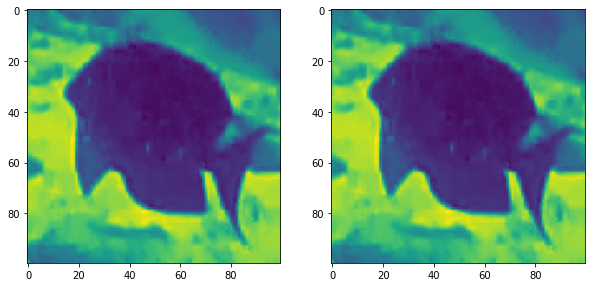

In [863]:
import random
path_name = os.path.join(dirname,img_meta_df['file_name'][random.randrange(len(img_meta_df))])

if os.path.exists(path_name):

    loaded_img = load_img(path_name,  color_mode="grayscale", target_size=(img_height, img_width), interpolation="nearest")
    img_array = img_to_array(loaded_img)

    processed_img_array = preprocess(img_array)
    fig, axs = plt.subplots(1,2,figsize=(10,10))
    axs[0].imshow(img_array)
    axs[1].imshow(processed_img_array)
    plt.show()

In [864]:
import sys
import matplotlib.pyplot as plt

img_meta_df = pd.read_csv("data/crop_metadata.csv")

dirname = "./data/crops"
processed_dirname = "./data/processed_crops"

(img_height, img_width) = (100, 100)
n_samples = 10000
i = 0

img_df = img_meta_df.copy()
img_arrays = np.ones((len(img_meta_df), img_height, img_width, 1), np.uint8)

for index, row in img_meta_df.iterrows():
    path_name = os.path.join(dirname, row['file_name'])

    if os.path.exists(path_name):
        
        loaded_img = load_img(path_name,  color_mode="grayscale", target_size=(img_height, img_width), interpolation="nearest")
        img_array = img_to_array(loaded_img)
        
        processed_img_array = preprocess(img_array)
        
        save_path = os.path.join(processed_dirname, row['file_name'])
        save_img(save_path, processed_img_array)
        i+=1
        
    if(i!=0 and i%n_samples == 0):
        #fig, axs = plt.subplots(1,2,figsize=(10,10))
        #axs[0].imshow(img_array)
        #axs[1].imshow(processed_img_array)
        #plt.show()
        
        print("{} samples processed\r".format(i), end="", flush=True)
        break
        
